# 02 - Bias Detection & Fairness

## 0. Setup

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# visual style
sns.set_theme(style='whitegrid', palette='Set2', font_scale=1.1)
pallete_colors = {'Male': '#E67E22', 'Female': '#9B59B6', 'Unknown': '#8c8c8c'}

In [25]:
# Load the cleaned data
df_clean = pd.read_csv('../data/processed/applications_clean.csv')

df = df_clean.copy() 

# Convert the date of birth column to actual dates
df['applicant_info.date_of_birth_clean'] = pd.to_datetime(
    df['applicant_info.date_of_birth_clean'], errors='coerce' # prevents an error if any value can't be read as a date 
)

# Creating a new column 'age' (reference date = 2024-01-01, consistent with dataset 'processing_timestamp' column)
ref_date = pd.Timestamp('2024-01-01')
df['age'] = ((ref_date - df['applicant_info.date_of_birth_clean']).dt.days / 365.25).round(1)

# Convert zip code to a string
df['applicant_info.zip_code'] = df['applicant_info.zip_code'].astype('Int64').astype(str).str.zfill(5)

# Rename columns for easier reference
df['gender'] = df['applicant_info.gender_clean']
df['loan_approved'] = df['decision.loan_approved']
df['income'] = df['financials.annual_income_clean']
df['debt_to_income'] = df['financials.debt_to_income_clean']
df['credit_history'] = df['financials.credit_history_months_clean']
df['savings'] = df['financials.savings_balance_clean']
df['zip_code'] = df['applicant_info.zip_code']
df['interest'] = df['decision.interest_rate']

print(f'Total Rows     : {len(df)}')
print(f'Loans Approved : {df["loan_approved"].sum()} ({df["loan_approved"].mean():.1%})')
print(f'Gender dist.   : {df["gender"].value_counts().to_dict()}')
print(f'Age range      : {round(df["age"].min())} - {round(df["age"].max())} yrs (median {round(df["age"].median())})')

Total Rows     : 502
Loans Approved : 292 (58.2%)
Gender dist.   : {'Female': 251, 'Male': 248, 'Unknown': 3}
Age range      : 22 - 65 yrs (median 37)


---
## 1. Gender Disparate Impact

In [ ]:
# Approval rates by gender 
gender_stats = (
    df[df['gender'].isin(['Male', 'Female'])]
    .groupby('gender')['loan_approved']
    .agg(total_applications='count', approved_applications='sum', approval_rate='mean')
    .reset_index()
)

print(gender_stats)

male_rate   = gender_stats.loc[gender_stats['gender']=='Male',   'approval_rate'].values[0]
female_rate = gender_stats.loc[gender_stats['gender']=='Female', 'approval_rate'].values[0]

# Identify which group has the lower rate as unprivileged
if female_rate <= male_rate:
    privileged, unprivileged = 'Male', 'Female'
    di_ratio = female_rate / male_rate
else:
    privileged, unprivileged = 'Female', 'Male'
    di_ratio = male_rate / female_rate

print(f'\nPrivileged group   : {privileged}  ({max(male_rate, female_rate):.1%} approval)')
print(f'Unprivileged group : {unprivileged}  ({min(male_rate, female_rate):.1%} approval)')
print(f'Disparate Impact   : {round(di_ratio, 4)}')
print(f'Four-fifths rule   : {"FAIL — potential disparate impact!" if di_ratio < 0.8 else "PASS"}')

   gender  total_applications  approved_applications  approval_rate
0  Female                 251                    127       0.505976
1    Male                 248                    163       0.657258

Privileged group   : Male  (65.7% approval)
Unprivileged group : Female  (50.6% approval)
Disparate Impact   : 0.7698
Four-fifths rule   : FAIL — potential disparate impact!


In [ ]:
# Statistical significance: chi-square test
contingency = pd.crosstab(
    df[df['gender'].isin(['Male','Female'])]['gender'],
    df[df['gender'].isin(['Male','Female'])]['loan_approved']
)

chi2, p_val, dof, _ = stats.chi2_contingency(contingency)
print(f'Chi-square = {chi2:.4f} \np-value = {p_val:.4f} \ndof = {dof}')
print('Result:', 'Statistically significant (p<0.05), thus there is less than a 5% chance it happened by random chance' if p_val < 0.05 
      else 'Not statistically significant, thus the gap could be random'
)

Chi-square = 11.1156 
p-value = 0.0009 
dof = 1
Result: Statistically significant (p<0.05), thus there is less than a 5% chance it happened by random chance


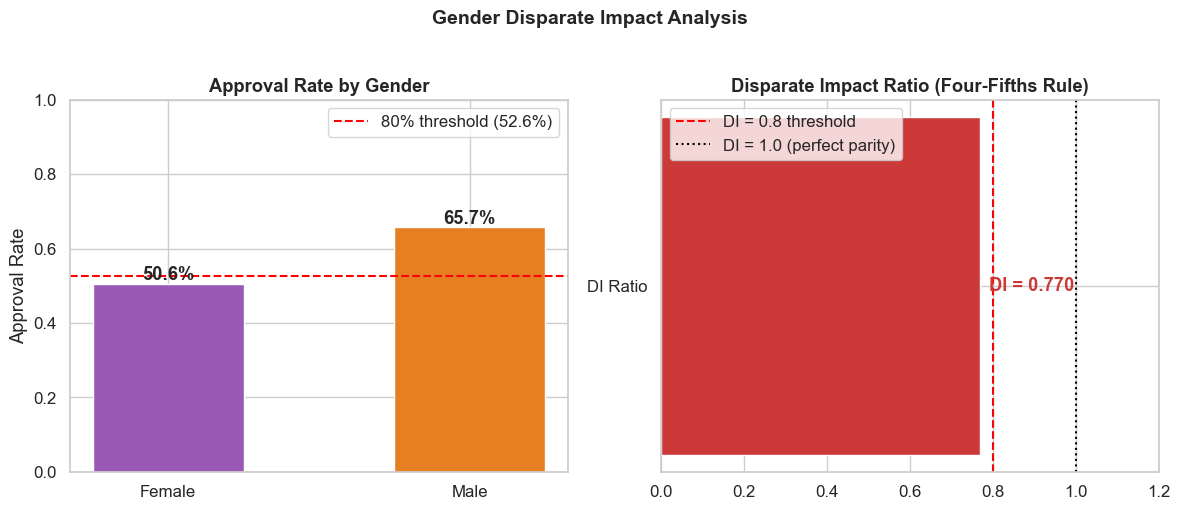

In [28]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar Chart for approval rate by gender
ax = axes[0]
bars = ax.bar(gender_stats['gender'], gender_stats['approval_rate'],
    color=[pallete_colors[g] for g in gender_stats['gender']],
    edgecolor='white', width=0.5
)

ax.axhline(0.8 * max(male_rate, female_rate), color='red', linestyle='--',
           label=f'80% threshold ({0.8*max(male_rate,female_rate):.1%})')

for bar, val in zip(bars, gender_stats['approval_rate']):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.01, f'{val:.1%}',
            ha='center', fontweight='bold')
    
ax.set_ylim(0, 1.0)
ax.set_title('Approval Rate by Gender', fontweight='bold')
ax.set_xlabel(''); ax.set_ylabel('Approval Rate')
ax.legend()

# Horizontal Bar Chart for DI 
ax2 = axes[1]
ax2.barh(['DI Ratio'], [di_ratio], color="#cc3939" if di_ratio < 0.8 else '#5ab375', height=0.3)
ax2.axvline(0.8, color='red', linestyle='--', label='DI = 0.8 threshold')
ax2.axvline(1.0, color='black', linestyle=':', label='DI = 1.0 (perfect parity)')
ax2.set_xlim(0, 1.2)
ax2.text(di_ratio + 0.02, 0, f'DI = {di_ratio:.3f}', va='center', fontweight='bold',
         color="#cc3939" if di_ratio < 0.8 else '#5ab375')
ax2.set_title('Disparate Impact Ratio (Four-Fifths Rule)', fontweight='bold')
ax2.legend()

plt.suptitle('Gender Disparate Impact Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 2. Age-Based Discrimination Patterns

In [29]:
# Create age groups
df_age = df.dropna(subset=['age']).copy()
bins   = [17, 25, 35, 45, 55, 65, 100]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
df_age['age_group'] = pd.cut(df_age['age'], bins=bins, labels=labels)

age_stats = (
    df_age.groupby('age_group', observed=True)['loan_approved']
    .agg(total_applications='count', approved_applications='sum', approval_rate='mean')
    .reset_index()
)
print(age_stats)

  age_group  total_applications  approved_applications  approval_rate
0     18-25                  42                     14       0.333333
1     26-35                 160                     84       0.525000
2     36-45                 165                    112       0.678788
3     46-55                  75                     45       0.600000
4     56-65                  53                     32       0.603774
5       65+                   2                      2       1.000000


In [ ]:
## Cutoff set at 35, since approval rate jumps significantly from 26-35 (52.5%) to 36-45 (67.9%)
rate_under35 = df_age[df_age['age'] <= 35]['loan_approved'].mean()
rate_over35  = df_age[df_age['age'] > 35]['loan_approved'].mean()

# Identify which group has the lower rate
if rate_under35 <= rate_over35:
    di_age = rate_under35 / rate_over35
else:
    di_age = rate_over35 / rate_under35

print(f'\nApproval rate <=35 : {rate_under35:.1%}')
print(f'Approval rate >35  : {rate_over35:.1%}')
print(f'Age DI             : {round(di_age, 4)}')
print('Four-fifths rule   :', 'FAIL — potential disparate impact!' if di_age < 0.8 else 'PASS')


Approval rate <=35 : 48.5%
Approval rate >35  : 64.7%
Age DI             : 0.7493
Four-fifths rule   : FAIL — potential disparate impact!


In [31]:
# Statistical significance: chi-square test
contingency_age = pd.crosstab(
    df_age['age'] <= 35,
    df_age['loan_approved']
)
chi2_age, p_val_age, dof_age, _ = stats.chi2_contingency(contingency_age)
print(f'Chi-square = {chi2_age:.4f} \np-value = {p_val_age:.4f} \ndof = {dof_age}')
print('Result:', 'Statistically significant (p<0.05), thus there is less than a 5% chance it happened by random chance' if p_val_age < 0.05 
      else 'Not statistically significant')

Chi-square = 12.3210 
p-value = 0.0004 
dof = 1
Result: Statistically significant (p<0.05), thus there is less than a 5% chance it happened by random chance


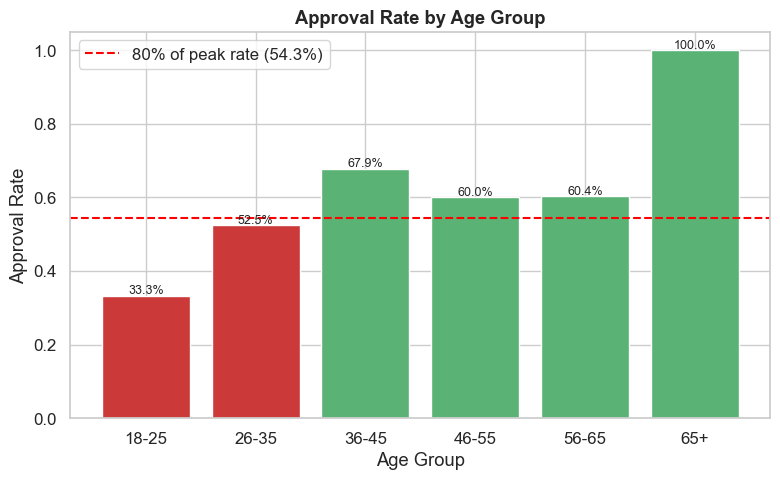

In [32]:
# Bar Chart for Approval Rate by Age Group
fig, ax = plt.subplots(figsize=(8, 5))

# 65+ was inflating the 80% threshold, and only has 2 applicantes
peak_rate = age_stats[age_stats['age_group'] != '65+']['approval_rate'].max() 

colors = []
for rate in age_stats['approval_rate']:
    if rate < 0.8 * peak_rate:
        colors.append("#cc3939")
    else:
        colors.append('#5ab375')
        
bars = ax.bar(age_stats['age_group'].astype(str), age_stats['approval_rate'],
              color=colors, edgecolor='white')

ax.axhline(0.8 * peak_rate, color='red', linestyle='--',
           label=f'80% of peak rate ({0.8 * peak_rate:.1%})')

for bar, val in zip(bars, age_stats['approval_rate']):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.005, f'{val:.1%}',
            ha='center', fontsize=9)
    
ax.set_title('Approval Rate by Age Group', fontweight='bold')
ax.set_xlabel('Age Group'); ax.set_ylabel('Approval Rate')
ax.legend()
plt.tight_layout()
plt.show()

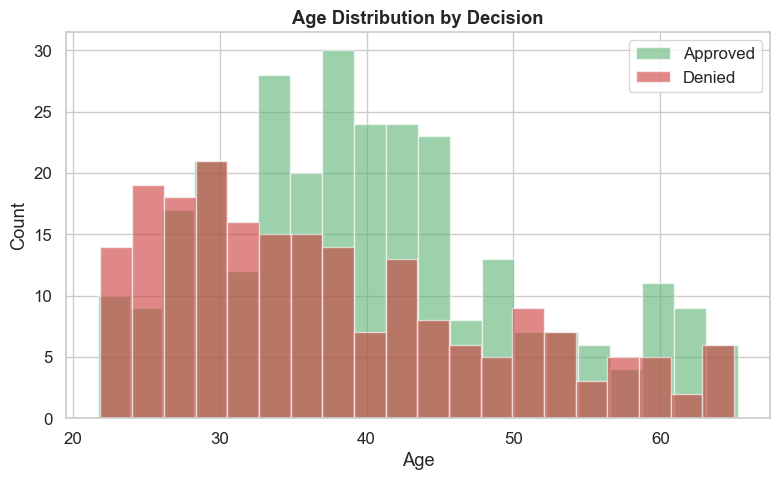

In [33]:
# Bar Chart for Age distribution - approved vs denied
fig, ax = plt.subplots(figsize=(8, 5))

df_age[df_age['loan_approved']==True]['age'].plot.hist(
    bins=20, ax=ax, alpha=0.6, color='#5ab375', label='Approved')
df_age[df_age['loan_approved']==False]['age'].plot.hist(
    bins=20, ax=ax, alpha=0.6, color="#cc3939", label='Denied')

ax.set_title('Age Distribution by Decision', fontweight='bold')
ax.set_xlabel('Age') 
ax.set_ylabel('Count')
ax.legend()
plt.tight_layout()
plt.show()